### 1. Import Libraries 

In [1]:
#%reload_ext autoreload
#%autoreload 2
%matplotlib notebook

In [2]:
PATH = "/home/khan74/scratch/new_DL_DES/"
sz=224
batch_size=64

In [3]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50, Xception
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import optimizers
from keras.applications.resnet50 import preprocess_input
from keras.models import load_model

Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd 
import numpy as np

In [5]:
import os
from os import listdir
from os.path import isfile, join, exists

### 2. Load Data / Create data_generators

In [6]:
train_df = pd.read_csv(PATH + 'deeplearning/data/training_set.csv')
val_df = pd.read_csv(PATH + 'deeplearning/data/validation_set.csv')
HP_crossmatch_df = pd.read_csv(PATH + 'deeplearning/data/high_prob_crossmatch_test_set.csv')
FO_crossmatch_df = pd.read_csv(PATH + 'deeplearning/data/full_overlap_crossmatch_test_set.csv')

#### flow_from_dir

In [7]:
train_data_dir = f'{PATH}deeplearning/data/train/'
validation_data_dir = f'{PATH}deeplearning/data/valid/'

HP_SDSS_test_data_dir = f'{PATH}deeplearning/data/HP_crossmatch_test/sdss/'
HP_DES_test_data_dir = f'{PATH}deeplearning/data/HP_crossmatch_test/des/'

FO_SDSS_test_data_dir = f'{PATH}deeplearning/data/FO_crossmatch_test/sdss/'
FO_DES_test_data_dir = f'{PATH}deeplearning/data/FO_crossmatch_test/des/'

In [8]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
vertical_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=45)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
vertical_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=45)




train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (sz, sz),
batch_size = batch_size, 
class_mode = "categorical",
shuffle = True,
interpolation = 'nearest')

validation_generator = valid_datagen.flow_from_directory(
validation_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = "categorical",
shuffle = False,
interpolation = 'nearest')




HP_SDSS_test_generator = test_datagen.flow_from_directory(
HP_SDSS_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

HP_DES_test_generator = test_datagen.flow_from_directory(
HP_DES_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)




FO_SDSS_test_generator = test_datagen.flow_from_directory(
FO_SDSS_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

FO_DES_test_generator = test_datagen.flow_from_directory(
FO_DES_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

Found 36620 images belonging to 2 classes.
Found 963 images belonging to 2 classes.
Found 1066 images belonging to 1 classes.
Found 1066 images belonging to 1 classes.
Found 12596 images belonging to 1 classes.
Found 12596 images belonging to 1 classes.


### 3. Load Model 

In [84]:
model_final = load_model(PATH + 'deeplearning/weights/Xception_Final.h5')

### 4. Load sklearn / Def metrics 

In [10]:
import itertools
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figure_size = (11, 6),
                          save=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.figure(figsize=figure_size)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    if save==1:
        plt.savefig('confusion_matrix.pdf')
        plt.savefig('confusion_matrix.png')

In [12]:
# Define probability threshold mask

def threshold_mask(pred_array, prob_threshold = 0.9999):
    ''' 
    returns the positions in the array where the probability for each class is greater than prob_threshold
    
    pred_array: A one-hot encoded array of softmax probability outputs 
    prob_threshold: Float b/w 0 and 1 to use as a threshold mask
    '''
    pred_class_indices = np.argmax(pred_array, axis=1)
    pos = np.where( pred_array[ range( pred_array.shape[0] ), pred_class_indices ] > prob_threshold )[0]
    return pos


In [13]:
# Define top n predictions mask

def top_pred_mask(pred_array, n_top_predictions = 5000 ):
    '''
    reversedurn the positions of top n most confident predictions
    
    pred_array: A one-reversedencoded array of softmax probability outputs
    n_top_predictions: Num of top predictions
    '''
    pred_class_indices = np.argmax(pred_array, axis=1)
    pos = np.argsort( pred_array[ range( pred_array.shape[0] ), pred_class_indices ] ) 
    mask = np.flip( pos )
    return mask[: n_top_predictions]

# Zeroth Recursion 

## Check Accuracy on FO 

### (i) SDSS 

In [14]:
FO_SDSS_predictions = model_final.predict_generator(FO_SDSS_test_generator,  verbose=1)

12596/12596 [==============================] - 746s 59ms/step


**Try Without ANY MASKS**

In [20]:
#mask = threshold_mask(FO_SDSS_predictions, prob_threshold=0.9999)
#mask = threshold_mask(FO_SDSS_predictions, prob_threshold=0.999999)
mask = top_pred_mask(FO_SDSS_predictions, 6000)

In [16]:
FO_SDSS_predicted_class_indices=np.argmax(FO_SDSS_predictions,axis=1)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array( [labels[k] for k in FO_SDSS_predicted_class_indices] )

filenames= np.array( FO_SDSS_test_generator.filenames )

results=pd.DataFrame({"Filename":filenames[mask],
                      "Pred Labels":predictions[mask],
                     "Predictions":FO_SDSS_predicted_class_indices[mask]})

In [17]:
results['OBJID'] = results['Filename'].apply(lambda x: x.split('/')[-1][:-4]).astype('int64') 
final = pd.merge(results, FO_crossmatch_df, left_on='OBJID', right_on='SDSS_OBJID')
final['Actuals'] = final['P_CS_DEBIASED'] > final['P_EL_DEBIASED']

In [18]:
final[['OBJID','Predictions','Actuals', 'Pred Labels', 'P_EL_DEBIASED', 'P_CS_DEBIASED']].head()

,OBJID,Predictions,Actuals,Pred Labels,P_EL_DEBIASED,P_CS_DEBIASED
0,587724241764483150,1,True,spiral,0.090,0.910
1,587731187799425268,0,False,elliptical,0.869,0.061
2,587731187797852647,1,True,spiral,0.123,0.824
3,587731187797918307,1,True,spiral,0.047,0.616
4,587731187797983525,1,True,spiral,0.219,0.781


In [19]:
final.shape

(6000, 250)

In [21]:
print( "Accuracy: ", metrics.accuracy_score(final['Actuals'], final['Predictions']) )
print( "f1_score: ", metrics.f1_score(final['Actuals'], final['Predictions']))

Accuracy:  0.9708333333333333
f1_score:  0.9711173460967156


<IPython.core.display.Javascript object>


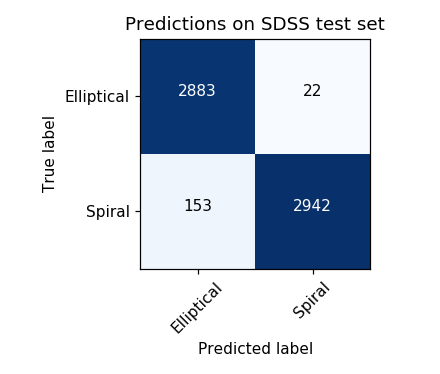

In [22]:
cm = confusion_matrix(final['Actuals'], final['Predictions'])
plot_confusion_matrix(cm, classes=['Elliptical', 'Spiral'], title="Predictions on SDSS test set", figure_size=(4,3.4))

### (ii) DES 

In [23]:
FO_DES_predictions = model_final.predict_generator(FO_DES_test_generator,  verbose=1)

12596/12596 [==============================] - 681s 54ms/step


In [24]:
#mask = threshold_mask(FO_DES_predictions, prob_threshold=0.999999)
mask = top_pred_mask(FO_DES_predictions, 6000)

In [25]:
FO_DES_predicted_class_indices=np.argmax(FO_DES_predictions,axis=1)

#FO_SDSS_predicted_class_indices = FO_SDSS_predicted_class_indices[pos]

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array( [labels[k] for k in FO_DES_predicted_class_indices] )

filenames= np.array( FO_DES_test_generator.filenames )

results=pd.DataFrame({"Filename":filenames[mask],
                      "Labels":predictions[mask],
                     "Predictions":FO_DES_predicted_class_indices[mask]})

In [26]:
results['OBJID'] = results['Filename'].apply(lambda x: x.split('/')[-1][:-4]).astype('int64') 
final = pd.merge(results, FO_crossmatch_df, left_on='OBJID', right_on='DES_COADD_OBJECT_ID')
final['Actuals'] = final['P_CS_DEBIASED'] > final['P_EL_DEBIASED']

In [27]:
final[['OBJID','Predictions','Actuals', 'Labels', 'P_EL_DEBIASED', 'P_CS_DEBIASED']].head()

,OBJID,Predictions,Actuals,Labels,P_EL_DEBIASED,P_CS_DEBIASED
0,100005001,1,True,spiral,0.048,0.923
1,254883056,1,True,spiral,0.085,0.915
2,254550652,1,True,spiral,0.000,1.000
3,254551412,1,True,spiral,0.102,0.772
4,123407560,1,True,spiral,0.028,0.953


In [28]:
final.shape

(6000, 250)

In [29]:
print( "Accuracy: ", metrics.accuracy_score(final['Actuals'], final['Predictions']) )
print( "f1_score: ", metrics.f1_score(final['Actuals'], final['Predictions']))

Accuracy:  0.968
f1_score:  0.9733481399222654


<IPython.core.display.Javascript object>


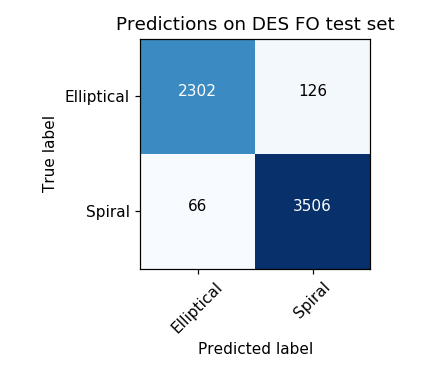

In [30]:
cm = confusion_matrix(final['Actuals'], final['Predictions'])
plot_confusion_matrix(cm, classes=['Elliptical', 'Spiral'], title="Predictions on DES FO test set", figure_size=(4,3.4))

## Extracting Training from Unlabelled DES 

In [31]:
UL_df = pd.read_csv(PATH + 'deeplearning/data/unlabelled_test_set.csv')

In [32]:
UL_test_data_dir = f'{PATH}deeplearning/data/unlabelled/'

In [33]:
UL_test_generator = test_datagen.flow_from_directory(
UL_test_data_dir,
target_size = (sz, sz),
batch_size = 1,
class_mode = None,
shuffle = False)

Found 8983 images belonging to 1 classes.


In [34]:
UL_predictions = model_final.predict_generator(UL_test_generator, verbose=1)

8983/8983 [==============================] - 586s 65ms/step


In [35]:
mask = top_pred_mask(UL_predictions, 4500)

In [36]:
UL_predicted_class_indices=np.argmax(UL_predictions,axis=1)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array( [labels[k] for k in UL_predicted_class_indices] )

filenames= np.array( UL_test_generator.filenames )

results=pd.DataFrame({"Filename":filenames[mask],
                      "Pred Labels":predictions[mask],
                     "Predictions":UL_predicted_class_indices[mask]})

In [37]:
mcs = np.flip( np.argsort(UL_predictions[:,1]) )[:500]
mce = np.flip( np.argsort(UL_predictions[:,0]) )[:500]

mcs_filenames= np.array( UL_test_generator.filenames )[mcs]
mce_filenames= np.array( UL_test_generator.filenames )[mce]

In [38]:
spirals = results[ results['Filename'].isin(mcs_filenames) ]
ellipticals = results[ results['Filename'].isin(mce_filenames) ]

In [39]:
training_df_1 = pd.concat([spirals, ellipticals])

In [40]:
training_df_1.Filename = training_df_1['Filename'].apply(lambda x: x.split('/')[-1] )

In [41]:
training_df_1.head()

,Filename,Pred Labels,Predictions
0,99944914.png,spiral,1
2,331360270.png,spiral,1
3,331275511.png,spiral,1
4,331226682.png,spiral,1
5,331143746.png,spiral,1


In [42]:
train_generator.class_indices

{'elliptical': 0, 'spiral': 1}

In [43]:
def plot_pred(df, start_index = 0):
    
    for i, index in enumerate( df.index[start_index:start_index+100] ):
    
        row = results.loc[index]
        filename = row.Filename
        type_ = row['Pred Labels']

        img_path = UL_test_data_dir + str(filename)

        img = plt.imread(img_path )

        plt.subplot(10,10,i+1)
        plt.axis('Off')
        plt.subplots_adjust(wspace=0.1,hspace=0.05)
        plt.imshow(img)
        plt.suptitle('Predicted ' + type_)
        
    plt.show()

<IPython.core.display.Javascript object>


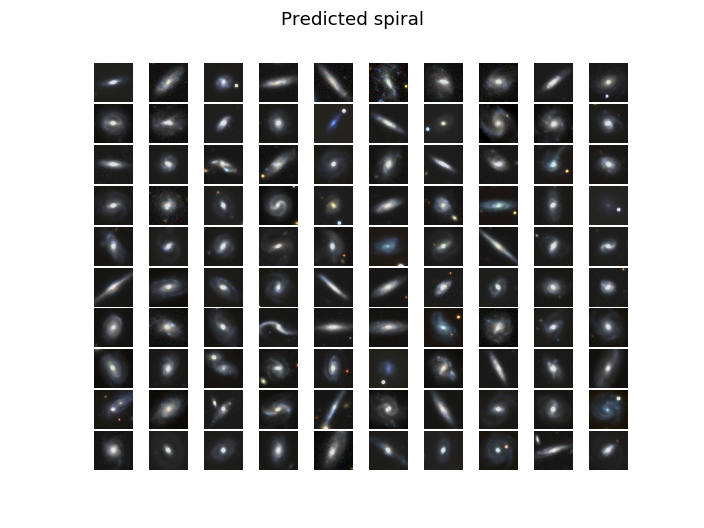

In [44]:
plot_pred(training_df_1[ training_df_1.Predictions==1 ], 400)

<IPython.core.display.Javascript object>


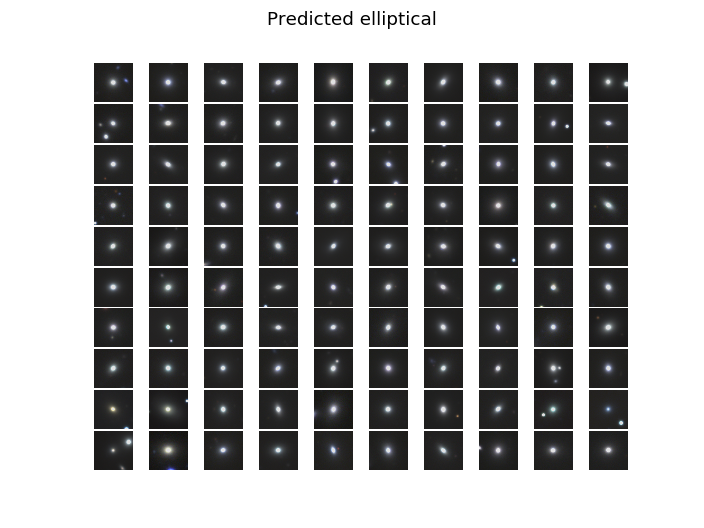

In [45]:
plot_pred(training_df_1[ training_df_1.Predictions==0 ], 400)

# 1st Recursion 

## Create Training Dir 

In [46]:
import pandas as pd
from subprocess import call
from pathlib import Path

In [47]:
PATH = '/home/khan74/scratch/new_DL_DES/'

In [48]:
file_path = Path( UL_test_data_dir + 'test/' )
link_path = Path( PATH + 'deeplearning/data/recursive')

In [56]:
for i in training_df_1.index:
    
    row = training_df_1.loc[i]
    filename = row.Filename
    
    if row.Predictions == 1:
        type = 'spiral'
    else:
        type = 'elliptical'
        
    img_path = file_path.joinpath(filename)
    soft_link_path = link_path.joinpath(type, filename)
    
    if not img_path.exists():
        print( 'Not Found: Image with OBJID %d' %objid)  
    if soft_link_path.exists():
        continue
    
    status = call(['cp', img_path, soft_link_path])
    if status != 0:
        print("Command failed with return code - ", status)


In [57]:
link_path

PosixPath('/home/khan74/scratch/new_DL_DES/deeplearning/data/recursive')

## Training 

In [58]:
rec_train_data_dir = f'{PATH}deeplearning/data/recursive/'

In [120]:
rec_train_generator = train_datagen.flow_from_dataframe(
dataframe = training_df_1,
directory = UL_test_data_dir + 'test/',
x_col = 'Filename',
y_col = 'Pred Labels',
has_ext = True,
target_size = (sz, sz),
batch_size = batch_size,
class_mode = "categorical",
classes = ['elliptical', 'spiral'],
shuffle = True,
interpolation = 'nearest')

Found 1000 images belonging to 2 classes.


In [85]:
rec_train_generator = train_datagen.flow_from_directory(
rec_train_data_dir,
target_size = (sz, sz),
batch_size = batch_size, 
class_mode = "categorical",
shuffle = True,
interpolation = 'nearest')

Found 1000 images belonging to 2 classes.


In [86]:
rec_train_generator.class_indices

{'elliptical': 0, 'spiral': 1}

In [87]:
train_generator.class_indices

{'elliptical': 0, 'spiral': 1}

In [88]:
validation_generator.class_indices

{'elliptical': 0, 'spiral': 1}

#### Freeze all base model layers 

In [89]:
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [90]:
len(model_final.layers)

137

In [92]:
split_at = 133
for layer in model_final.layers[:split_at]: layer.trainable = False
for layer in model_final.layers[split_at:]: layer.trainable = True  
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001/100), metrics=["accuracy"])

In [93]:
history_1 = model_final.fit_generator(
rec_train_generator,
steps_per_epoch = rec_train_generator.n // rec_train_generator.batch_size,
epochs = 3,
validation_data = validation_generator,
validation_steps = validation_generator.n // validation_generator.batch_size)

Epoch 1/3
15/15 [==============================] - 25s 2s/step - loss: 0.0019 - acc: 0.9990 - val_loss: 0.0049 - val_acc: 0.9979
Epoch 2/3
15/15 [==============================] - 23s 2s/step - loss: 0.0030 - acc: 0.9979 - val_loss: 0.0049 - val_acc: 0.9979
Epoch 3/3
15/15 [==============================] - 22s 1s/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 0.9979


#### (ii) Unfreeze [at Layer 40]

In [67]:
len(model_final.layers)

137

In [68]:
split_at = 40
for layer in model_final.layers[:split_at]: layer.trainable = False
for layer in model_final.layers[split_at:]: layer.trainable = True  
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"])

In [69]:
history_2 = model_final.fit_generator(
rec_train_generator,
steps_per_epoch = rec_train_generator.n // rec_train_generator.batch_size,
epochs = 2,
validation_data = validation_generator,
validation_steps = validation_generator.n // validation_generator.batch_size)

Epoch 1/2
15/15 [==============================] - 23s 2s/step - loss: 9.6074e-04 - acc: 0.9990 - val_loss: 0.0509 - val_acc: 0.9969
Epoch 2/2
15/15 [==============================] - 22s 1s/step - loss: 3.1641e-05 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 0.9969


#### (iii) Unfreeze [at Layer 2] 

In [82]:
split_at = 2
for layer in model_final.layers[:split_at]: layer.trainable = False
for layer in model_final.layers[split_at:]: layer.trainable = True  
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001/100), metrics=["accuracy"])

In [83]:
history_3 = model_final.fit_generator(
rec_train_generator,
steps_per_epoch = rec_train_generator.n // rec_train_generator.batch_size,
epochs = 3,
validation_data = validation_generator,
validation_steps = validation_generator.n // validation_generator.batch_size)

Epoch 1/3
15/15 [==============================] - 35s 2s/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9875
Epoch 2/3
15/15 [==============================] - 23s 2s/step - loss: 9.9118e-04 - acc: 1.0000 - val_loss: 0.0707 - val_acc: 0.9855
Epoch 3/3
15/15 [==============================] - 23s 2s/step - loss: 0.0020 - acc: 0.9990 - val_loss: 0.0688 - val_acc: 0.9865


## Check Accuracy on FO 

### (i) SDSS 

In [128]:
FO_SDSS_predictions = model_final.predict_generator(FO_SDSS_test_generator,  verbose=1)

12596/12596 [==============================] - 577s 46ms/step


In [129]:
#mask = threshold_mask(FO_SDSS_predictions, prob_threshold=0.9999)
#mask = threshold_mask(FO_SDSS_predictions, prob_threshold=0.999999)
mask = top_pred_mask(FO_SDSS_predictions, 6000)

In [130]:
FO_SDSS_predicted_class_indices=np.argmax(FO_SDSS_predictions,axis=1)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array( [labels[k] for k in FO_SDSS_predicted_class_indices] )

filenames= np.array( FO_SDSS_test_generator.filenames )

results=pd.DataFrame({"Filename":filenames[mask],
                      "Pred Labels":predictions[mask],
                     "Predictions":FO_SDSS_predicted_class_indices[mask]})

In [131]:
results['OBJID'] = results['Filename'].apply(lambda x: x.split('/')[-1][:-4]).astype('int64') 
final = pd.merge(results, FO_crossmatch_df, left_on='OBJID', right_on='SDSS_OBJID')
final['Actuals'] = final['P_CS_DEBIASED'] > final['P_EL_DEBIASED']

In [132]:
final[['OBJID','Predictions','Actuals', 'Pred Labels', 'P_EL_DEBIASED', 'P_CS_DEBIASED']].head()

,OBJID,Predictions,Actuals,Pred Labels,P_EL_DEBIASED,P_CS_DEBIASED
0,587724241764483150,1,True,spiral,0.090,0.910
1,587731187797525106,1,True,spiral,0.158,0.842
2,587731187797590632,0,False,elliptical,0.557,0.443
3,587731187797655568,0,False,elliptical,0.842,0.158
4,587731187797655871,1,True,spiral,0.048,0.952


In [133]:
final.shape

(6000, 250)

In [134]:
print( "Accuracy: ", metrics.accuracy_score(final['Actuals'], final['Predictions']) )
print( "f1_score: ", metrics.f1_score(final['Actuals'], final['Predictions']))

Accuracy:  0.9618333333333333
f1_score:  0.9604831751509924


<IPython.core.display.Javascript object>


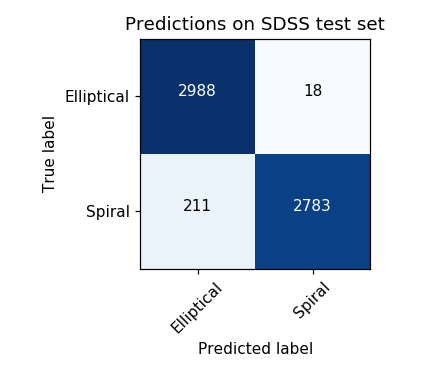

In [135]:
cm = confusion_matrix(final['Actuals'], final['Predictions'])
plot_confusion_matrix(cm, classes=['Elliptical', 'Spiral'], title="Predictions on SDSS test set", figure_size=(4,3.4))

### (ii) DES 

In [94]:
FO_DES_predictions = model_final.predict_generator(FO_DES_test_generator,  verbose=1)

12596/12596 [==============================] - 455s 36ms/step


In [95]:
#mask = threshold_mask(FO_DES_predictions, prob_threshold=0.999999)
mask = top_pred_mask(FO_DES_predictions, 6000)

In [96]:
FO_DES_predicted_class_indices=np.argmax(FO_DES_predictions,axis=1)

#FO_SDSS_predicted_class_indices = FO_SDSS_predicted_class_indices[pos]

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array( [labels[k] for k in FO_DES_predicted_class_indices] )

filenames= np.array( FO_DES_test_generator.filenames )

results=pd.DataFrame({"Filename":filenames[mask],
                      "Labels":predictions[mask],
                     "Predictions":FO_DES_predicted_class_indices[mask]})

In [97]:
results['OBJID'] = results['Filename'].apply(lambda x: x.split('/')[-1][:-4]).astype('int64') 
final = pd.merge(results, FO_crossmatch_df, left_on='OBJID', right_on='DES_COADD_OBJECT_ID')
final['Actuals'] = final['P_CS_DEBIASED'] > final['P_EL_DEBIASED']

In [98]:
final[['OBJID','Predictions','Actuals', 'Labels', 'P_EL_DEBIASED', 'P_CS_DEBIASED']].head()

,OBJID,Predictions,Actuals,Labels,P_EL_DEBIASED,P_CS_DEBIASED
0,100005001,1,True,spiral,0.048,0.923
1,232975141,1,True,spiral,0.055,0.820
2,192953782,1,True,spiral,0.043,0.957
3,334399784,0,False,elliptical,0.666,0.233
4,192953183,1,True,spiral,0.014,0.986


In [99]:
final.shape

(6000, 250)

In [100]:
print( "Accuracy: ", metrics.accuracy_score(final['Actuals'], final['Predictions']) )
print( "f1_score: ", metrics.f1_score(final['Actuals'], final['Predictions']))

Accuracy:  0.9678333333333333
f1_score:  0.973272399944606


<IPython.core.display.Javascript object>


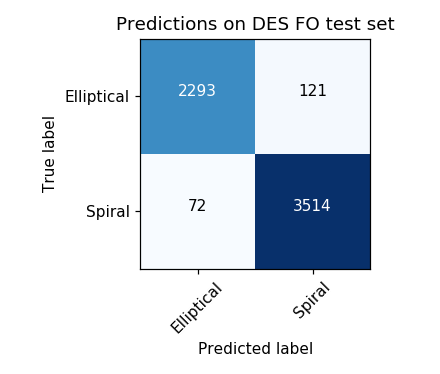

In [101]:
cm = confusion_matrix(final['Actuals'], final['Predictions'])
plot_confusion_matrix(cm, classes=['Elliptical', 'Spiral'], title="Predictions on DES FO test set", figure_size=(4,3.4))